In [9]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # Set GPU Index to use
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from torch.utils.tensorboard import SummaryWriter

from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
        
def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None:
                logits, teacher_atts, _, teacher_probs, _ = teacher_model(input_ids, segment_ids, input_mask)
                # teacher_probs = 0
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask, teacher_probs=teacher_probs)
            else:
                logits, _, _, _, _ = model(input_ids, segment_ids, input_mask)
        
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

def soft_cross_entropy(predicts, targets):
    student_likelihood = torch.nn.functional.log_softmax(predicts, dim=-1)
    targets_prob = torch.nn.functional.softmax(targets, dim=-1)
    return torch.sum((- targets_prob * student_likelihood), dim=-1).mean()

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

In [20]:
task_name = "sts-b"
bert_size = "large"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else:
    layer_num = 12
    head_num = 12

### Device & Dataset

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

teacher_model_dir = os.path.join(model_dir,task_name)

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

eval_examples = processor.get_dev_examples(data_dir)

# Sampling Sentence 
i = 0 
# num = 3
num = 10

for step, batch in enumerate(eval_dataloader):
    # model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    i = i + 1
    if i == num:
        break

seq_length = seq_lengths.item()

input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)



sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)

04/22 03:19:55 PM Writing example 0 of 1500
04/22 03:19:55 PM *** Example ***
04/22 03:19:55 PM guid: dev-0
04/22 03:19:55 PM tokens: [CLS] a man with a hard hat is dancing . [SEP] a man wearing a hard hat is dancing . [SEP]
04/22 03:19:55 PM input_ids: 101 1037 2158 2007 1037 2524 6045 2003 5613 1012 102 1037 2158 4147 1037 2524 6045 2003 5613 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
04/22 03:19:55 PM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
04/22 03:19:55 PM segment_ids: 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

/tmp/ipykernel_3835806/2442338932.py:41: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)


In [29]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
mse_func = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

student_model_dir = os.path.join(model_dir,task_name)

# st_model_name = "ternary_save"
# st_model_name = "step_2_context"
# st_model_name = "step_2_output"
# st_model_name = "step_2"
# st_model_name = "sarq_step1"



build_tc = 1
build_st = 1

if build_tc:
    # Teacher Model Build
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()
    model = teacher_model

    
ternary_name = "ternary_save"
sarq_name_1 = "step_2"
sarq_name_2 = "step_2_output_ti_"
sarq_name_3 = "step_2_output_ci_"

for st_model_name in [ternary_name, sarq_name_1, sarq_name_2, sarq_name_3]:
    student_model_dir = os.path.join(output_dir, task_name, "quant", st_model_name)   

    if build_st:
        # Student Model Build
        student_config = BertConfig.from_pretrained(student_model_dir)
#                                                         quantize_act=True,
#                                                         quantize_weight=True,
#                                                         weight_bits = 2, # Always Ternary when "quantize_weight = True"
#                                                         input_bits = 8,
#                                                         clip_val = 2.5,
#                                                         quantize = True,
#                                                         ffn_q_1 = True,
#                                                         ffn_q_2 = True,
#                                                         qkv_q = True,
#                                                         emb_q = True,
#                                                         cls_q = True,
#                                                         clipping = False,
#                                                         layer_num = -1,
#                                                         mean_scale = 0.7,
#                                                         quantizer = "ternary",
#                                                         act_quantizer = "ternary",
#                                                         init_scaling = 1,
#                                                         clip_ratio = 1,
#                                                         gradient_scaling = False,
#                                                         clip_method = "minmax",
#                                                         teacher_attnmap = False,
#                                                         parks = False,
#                                                         stop_grad = False,
#                                                         qk_FP = False,
#                                                         map=False,
#                                                         act_method = "clipping"
#                                                         )

        student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
        student_model.to(device)
        model = student_model
        print()

        # Quantization Option ACT/WEIGHT
        for name, module in student_model.named_modules():
            if isinstance(module, (QuantizeLinear, QuantizeAct, ClipLinear)):    
                module.act_flag = True
                module.weight_flag = True

    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)
    teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids_sliced.to(device))
    student_logits, student_atts, student_reps, student_probs, student_values = student_model(input_ids_sliced.to(device), teacher_probs=teacher_probs)

    st_values = student_values
    tc_values = teacher_values

    norm_type = 0 # 1 : Attention Output 0 : Layer Context

    h_num = 1
    sep_list = []
    cls_list = []
    punc_list = []
    other_list = []

    for l in range(layer_num):
        for h in range(head_num): 

            if len(sep_index) == 2:
                diff_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
                diff_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
                sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
            else:
                diff_sep = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
                sep_list.append(diff_sep.item())

            diff_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
            cls_list.append((diff_cls).item())

            if len(sep_index) == 2:
                diff_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
                diff_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
                punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
            else:
                diff_punc = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
                punc_list.append((diff_punc).item())

            if len(sep_index) == 2:
                st_values[l][norm_type][0,h,sep_index[0],:] = 0
                tc_values[l][norm_type][0,h,sep_index[0],:] = 0        
                st_values[l][norm_type][0,h,sep_index[1],:] = 0
                tc_values[l][norm_type][0,h,sep_index[1],:] = 0
            else:
                st_values[l][norm_type][0,h,sep_index[0],:] = 0
                tc_values[l][norm_type][0,h,sep_index[0],:] = 0        

            if len(sep_index) == 2:        
                st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0        
                st_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
            else:
                st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
                tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0

            st_values[l][norm_type][0,h,0,:] = 0
            tc_values[l][norm_type][0,h,0,:] = 0

            diff_other = mse_func(st_values[l][norm_type][0,h,:,:], tc_values[l][norm_type][0,h,:,:])
            other_list.append(diff_other.item())


    if st_model_name == ternary_name:
        print(st_model_name)
        v_t_sep = sep_list 
        v_t_cls = cls_list 
        v_t_punc = punc_list 
        v_t_other = other_list 
    elif st_model_name == sarq_name_1:
        print(st_model_name)    
        v_s_sep = sep_list 
        v_s_cls = cls_list 
        v_s_punc = punc_list 
        v_s_other = other_list 
    elif st_model_name == sarq_name_2:
        print(st_model_name)
        v_sc_sep = sep_list 
        v_sc_cls = cls_list 
        v_sc_punc = punc_list 
        v_sc_other = other_list         
    elif st_model_name == sarq_name_3: 
        print(st_model_name)
        v_so_sep = sep_list 
        v_so_cls = cls_list 
        v_so_punc = punc_list 
        v_so_other = other_list   

    norm_type = 1 # 1 : Attention Output 0 : Layer Context
#    norm_type = 1 # 0 : Context 1 : Value

    h_num = 1
    sep_list = []
    cls_list = []
    punc_list = []
    other_list = []

    tokens
    for l in range(layer_num):
        if len(sep_index) == 2:
            diff_sep_1 = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
            diff_sep_2 = mse_func(st_values[l][norm_type][0,sep_index[1],:], tc_values[l][norm_type][0,sep_index[1],:]) 
            sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
        else:
            diff_sep = mse_func(st_values[l][norm_type][0,sep_index[0],:], tc_values[l][norm_type][0,sep_index[0],:]) 
            sep_list.append(diff_sep.item())

        diff_cls = mse_func(st_values[l][norm_type][0,0,:], tc_values[l][norm_type][0,0,:])
        cls_list.append((diff_cls).item())

        if len(sep_index) == 2:
            diff_punc_1 = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
            diff_punc_2 = mse_func(st_values[l][norm_type][0,sep_index[1]-1,:], tc_values[l][norm_type][0,sep_index[1]-1,:]) 
            punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
        else:
            diff_punc = mse_func(st_values[l][norm_type][0,sep_index[0]-1,:], tc_values[l][norm_type][0,sep_index[0]-1,:])
            punc_list.append((diff_punc).item())

        if len(sep_index) == 2:
            st_values[l][norm_type][0,sep_index[0],:] = 0
            tc_values[l][norm_type][0,sep_index[0],:] = 0        
            st_values[l][norm_type][0,sep_index[1],:] = 0
            tc_values[l][norm_type][0,sep_index[1],:] = 0
        else:
            st_values[l][norm_type][0,sep_index[0],:] = 0
            tc_values[l][norm_type][0,sep_index[0],:] = 0        

        if len(sep_index) == 2:        
            st_values[l][norm_type][0,sep_index[0]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[0]-1,:] = 0        
            st_values[l][norm_type][0,sep_index[1]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[1]-1,:] = 0
        else:
            st_values[l][norm_type][0,sep_index[0]-1,:] = 0
            tc_values[l][norm_type][0,sep_index[0]-1,:] = 0

        st_values[l][norm_type][0,0,:] = 0
        tc_values[l][norm_type][0,0,:] = 0

        diff_other = mse_func(st_values[l][norm_type][0,:,:], tc_values[l][norm_type][0,:,:])
        other_list.append(diff_other.item())

#     for l in range(layer_num):
#         for h in range(head_num): 

#             if len(sep_index) == 2:
#                 diff_sep_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
#                 diff_sep_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1],:], tc_values[l][norm_type][0,h,sep_index[1],:]) 
#                 sep_list.append(((diff_sep_1 + diff_sep_2) / 2).item())
#             else:
#                 diff_sep = mse_func(st_values[l][norm_type][0,h,sep_index[0],:], tc_values[l][norm_type][0,h,sep_index[0],:]) 
#                 sep_list.append(diff_sep.item())

#             diff_cls = mse_func(st_values[l][norm_type][0,h,0,:], tc_values[l][norm_type][0,h,0,:])
#             cls_list.append((diff_cls).item())

#             if len(sep_index) == 2:
#                 diff_punc_1 = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
#                 diff_punc_2 = mse_func(st_values[l][norm_type][0,h,sep_index[1]-1,:], tc_values[l][norm_type][0,h,sep_index[1]-1,:]) 
#                 punc_list.append(((diff_punc_1 + diff_punc_2) / 2).item())
#             else:
#                 diff_punc = mse_func(st_values[l][norm_type][0,h,sep_index[0]-1,:], tc_values[l][norm_type][0,h,sep_index[0]-1,:])
#                 punc_list.append((diff_punc).item())

#             if len(sep_index) == 2:
#                 st_values[l][norm_type][0,h,sep_index[0],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0],:] = 0        
#                 st_values[l][norm_type][0,h,sep_index[1],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[1],:] = 0
#             else:
#                 st_values[l][norm_type][0,h,sep_index[0],:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0],:] = 0        

#             if len(sep_index) == 2:        
#                 st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0        
#                 st_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[1]-1,:] = 0
#             else:
#                 st_values[l][norm_type][0,h,sep_index[0]-1,:] = 0
#                 tc_values[l][norm_type][0,h,sep_index[0]-1,:] = 0

#             st_values[l][norm_type][0,h,0,:] = 0
#             tc_values[l][norm_type][0,h,0,:] = 0

#             diff_other = mse_func(st_values[l][norm_type][0,h,:,:], tc_values[l][norm_type][0,h,:,:])
#             other_list.append(diff_other.item())

    if st_model_name == ternary_name:
        print(st_model_name)
        vw_t_sep = sep_list 
        vw_t_cls = cls_list 
        vw_t_punc = punc_list 
        vw_t_other = other_list 
    elif st_model_name == sarq_name_1:
        print(st_model_name)
        vw_s_sep = sep_list 
        vw_s_cls = cls_list 
        vw_s_punc = punc_list 
        vw_s_other = other_list 
    elif st_model_name == sarq_name_2:
        print(st_model_name)
        vw_sc_sep = sep_list 
        vw_sc_cls = cls_list 
        vw_sc_punc = punc_list 
        vw_sc_other = other_list   
    elif st_model_name == sarq_name_3: 
        print(st_model_name)
        vw_so_sep = sep_list 
        vw_so_cls = cls_list 
        vw_so_punc = punc_list 
        vw_so_other = other_list   
    
    kld_list = []
    
    for l in range(layer_num):
        for h in range(head_num): 
            student = student_probs[l][0,h,:,:]
            teacher = teacher_probs[l][0,h,:,:]
            neg_cross_entropy = teacher * torch.log(student) 
            neg_cross_entropy = torch.sum(neg_cross_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)


            # p(t) log p(t) = negative entropy
            neg_entropy = teacher * torch.log(teacher) 
            neg_entropy = torch.sum(neg_entropy, dim=-1)  # (b, h, s, s) -> (b, h, s)

            kl_div = neg_entropy - neg_cross_entropy
            # print(kl_div.mean().item())
            kld_list.append(kl_div.mean().item())
            
    if st_model_name == ternary_name:
        print(st_model_name)
        kl_t = kld_list
    elif st_model_name == sarq_name_1:
        print(st_model_name)
        kl_s = kld_list
    elif st_model_name == sarq_name_2:
        print(st_model_name)
        kl_s_c = kld_list
    elif st_model_name == sarq_name_3: 
        print(st_model_name)
        kl_s_o = kld_list




04/22 03:52:31 PM Loading model models/BERT_large/sts-b/pytorch_model.bin
04/22 03:52:32 PM loading model...
04/22 03:52:32 PM done!
04/22 03:52:32 PM loading configuration file output/BERT_large/sts-b/quant/ternary_save/config.json
04/22 03:52:37 PM Loading model output/BERT_large/sts-b/quant/ternary_save/pytorch_model.bin
04/22 03:52:39 PM loading model...
04/22 03:52:39 PM done!

ternary_save
ternary_save
ternary_save
04/22 03:52:40 PM loading configuration file output/BERT_large/sts-b/quant/step_2/config.json
04/22 03:52:46 PM Loading model output/BERT_large/sts-b/quant/step_2/pytorch_model.bin
04/22 03:52:47 PM loading model...
04/22 03:52:47 PM done!

step_2
step_2
step_2
04/22 03:52:48 PM loading configuration file output/BERT_large/sts-b/quant/step_2_output_ti_/config.json
04/22 03:52:54 PM Loading model output/BERT_large/sts-b/quant/step_2_output_ti_/pytorch_model.bin
04/22 03:52:55 PM loading model...
04/22 03:52:55 PM done!

step_2_output_ti_
step_2_output_ti_
step_2_output_

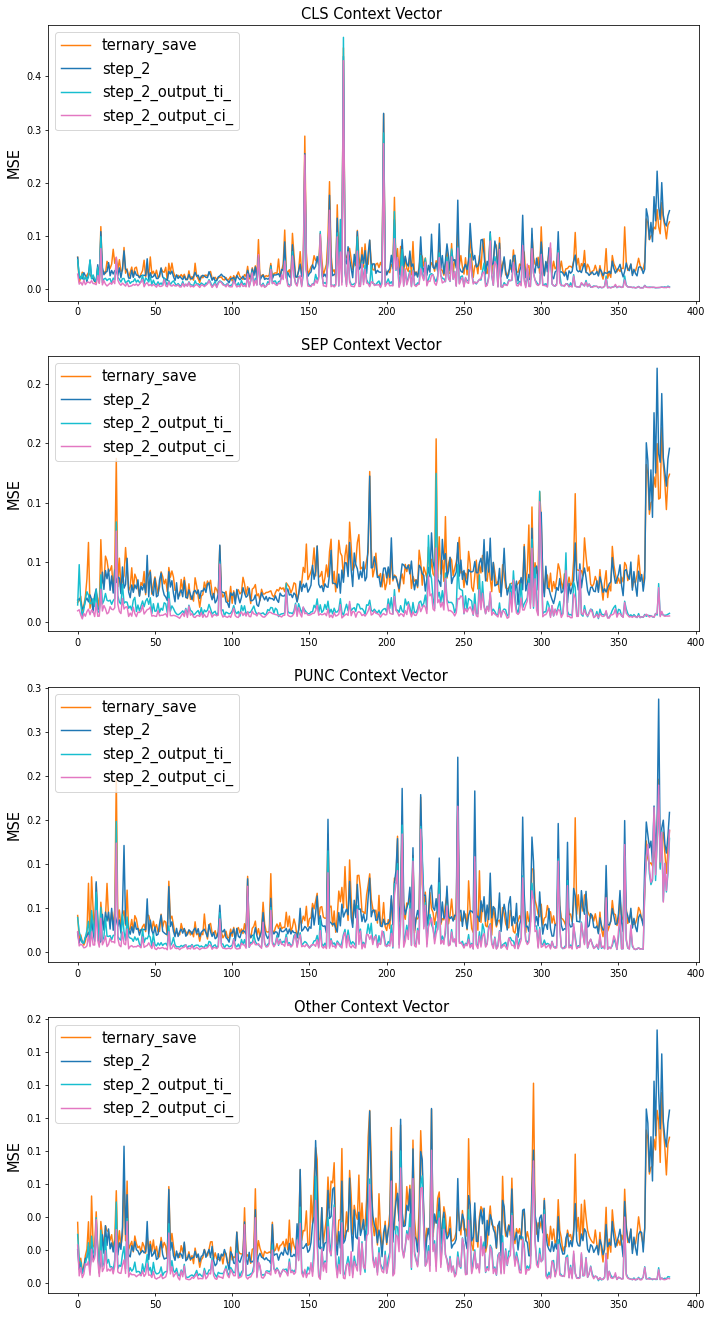

=> LayerNorm Output


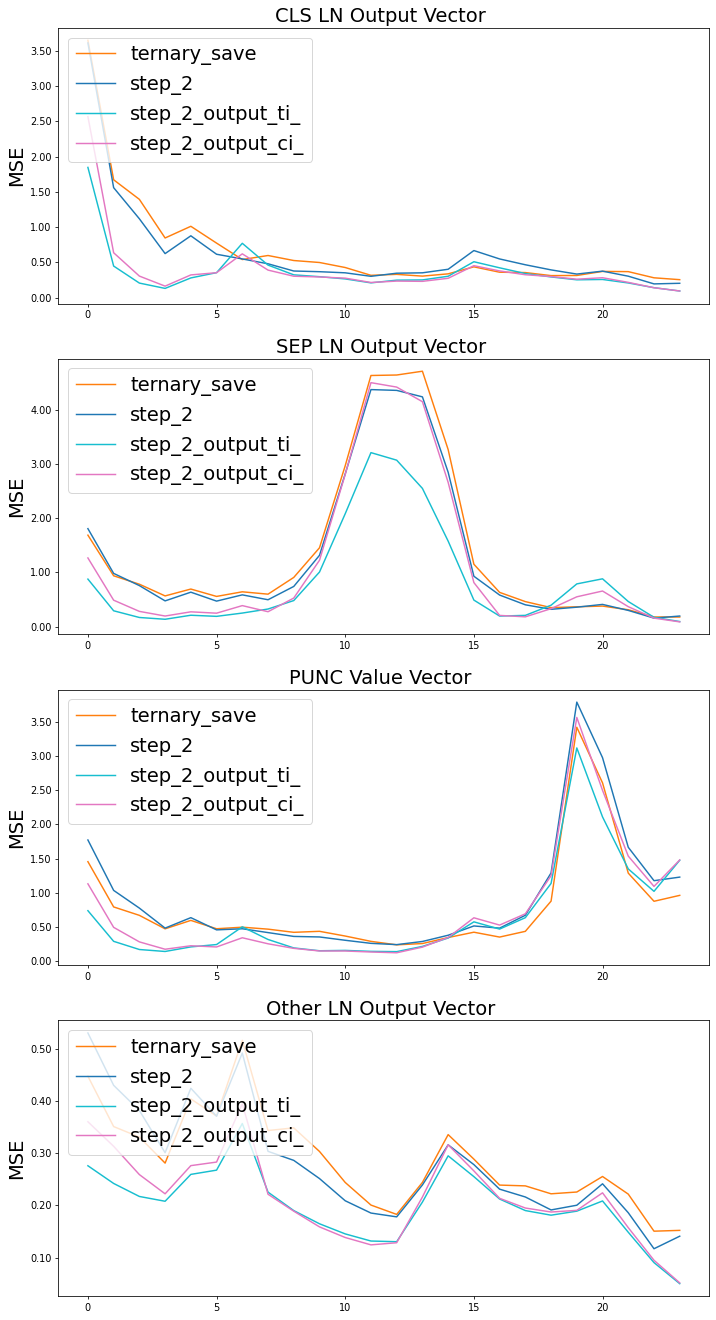

=> Attention Map KL Distance


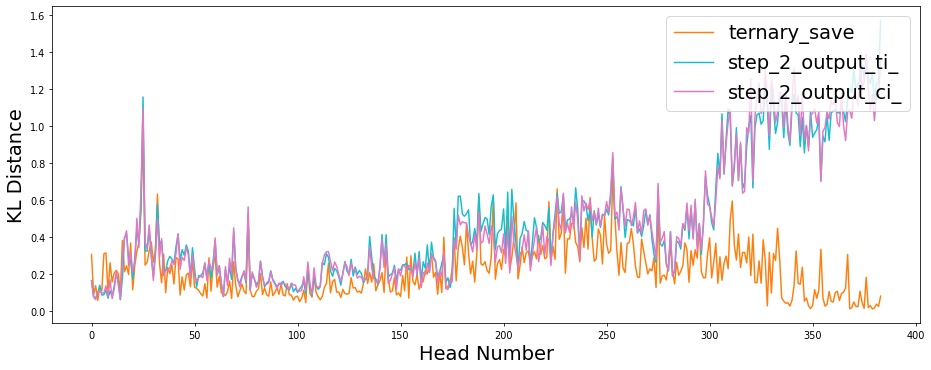

In [30]:
import matplotlib.ticker as mtick
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(12, 24), dpi=70)
font_size = 15
line_w =1.5

x_axis_num = layer_num * head_num
ax1_color = "tab:orange"
sarq_color = "tab:blue"
sarq_output_color_1 = "tab:cyan"
sarq_output_color_2 = "tab:pink"

# def plot(ax, dics):
#     for dic in dics
#         ax.plot(dic)

ax1.plot(list(range(x_axis_num)),v_t_cls, label=ternary_name, color=ax1_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),v_s_cls, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),v_sc_cls, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),v_so_cls, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax1.legend(fontsize=font_size, loc=2)
ax1.set_ylabel("MSE", fontsize=font_size)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax1.set_title("CLS Context Vector ", fontsize=font_size, fontweight="light")


ax2.plot(list(range(x_axis_num)),v_t_sep, label=ternary_name, color=ax1_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),v_s_sep, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),v_sc_sep, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),v_so_sep, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax2.legend(fontsize=font_size, loc=2)
ax2.set_ylabel("MSE", fontsize=font_size)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax2.set_title("SEP Context Vector ", fontsize=font_size, fontweight="light")

ax3.plot(list(range(x_axis_num)),v_t_punc, label=ternary_name, color=ax1_color, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),v_s_punc, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),v_sc_punc, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),v_so_punc, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax3.legend(fontsize=font_size, loc=2)
ax3.set_ylabel("MSE", fontsize=font_size)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax3.set_title("PUNC Context Vector ", fontsize=font_size, fontweight="light")

ax4.plot(list(range(x_axis_num)),v_t_other, label=ternary_name, color=ax1_color, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),v_s_other, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),v_sc_other, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),v_so_other, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax4.legend(fontsize=font_size, loc=2)
ax4.set_ylabel("MSE", fontsize=font_size)
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax4.set_title("Other Context Vector ", fontsize=font_size, fontweight="light")
plt.show()

print("=====================================================================================================================")
print("=> LayerNorm Output") 
# print("=> Value Output") 
print("=====================================================================================================================")

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=(12, 24), dpi=70)
line_w =1.5
font_size = 20
x_axis_num = layer_num

ax1.plot(list(range(x_axis_num)),vw_t_cls, label=ternary_name, color=ax1_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),vw_s_cls, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),vw_sc_cls, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax1.plot(list(range(x_axis_num)),vw_so_cls, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax1.legend(fontsize=font_size, loc=2)
ax1.set_ylabel("MSE", fontsize=font_size)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax1.set_title("CLS LN Output Vector ", fontsize=font_size, fontweight="light")

ax2.plot(list(range(x_axis_num)),vw_t_sep, label=ternary_name, color=ax1_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),vw_s_sep, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),vw_sc_sep, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax2.plot(list(range(x_axis_num)),vw_so_sep, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax2.legend(fontsize=font_size, loc=2)
ax2.set_ylabel("MSE", fontsize=font_size)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax2.set_title("SEP LN Output Vector ", fontsize=font_size, fontweight="light")

ax3.plot(list(range(x_axis_num)),vw_t_punc, label=ternary_name, color=ax1_color, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),vw_s_punc, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),vw_sc_punc, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax3.plot(list(range(x_axis_num)),vw_so_punc, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax3.legend(fontsize=font_size, loc=2)
ax3.set_ylabel("MSE", fontsize=font_size)
ax3.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax3.set_title("PUNC Value Vector ", fontsize=font_size, fontweight="light")

ax4.plot(list(range(x_axis_num)),vw_t_other, label=ternary_name, color=ax1_color, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),vw_s_other, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),vw_sc_other, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax4.plot(list(range(x_axis_num)),vw_so_other, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)

ax4.legend(fontsize=font_size, loc=2)
ax4.set_ylabel("MSE", fontsize=font_size)
ax4.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax4.set_title("Other LN Output Vector ", fontsize=font_size, fontweight="light")
plt.show()

print("=====================================================================================================================")
print("=> Attention Map KL Distance")
print("=====================================================================================================================")

x_axis_num = layer_num * head_num
font_size = 20
fig, ax = plt.subplots(1,1, figsize=(16, 6), dpi=70)
ax.plot(list(range(x_axis_num)),kl_t, label=ternary_name, color=ax1_color, linewidth=line_w)
# ax.plot(list(range(x_axis_num)),kl_s, label=sarq_name_1, color=sarq_color, linewidth=line_w)
ax.plot(list(range(x_axis_num)),kl_s_c, label=sarq_name_2, color=sarq_output_color_1, linewidth=line_w)
ax.plot(list(range(x_axis_num)),kl_s_o, label=sarq_name_3, color=sarq_output_color_2, linewidth=line_w)
ax.set_ylabel("KL Distance", fontsize=font_size)
ax.set_xlabel("Head Number", fontsize=font_size)
ax.legend(fontsize=font_size, loc=1)



In [19]:
build_tc = 1
build_st = 1

eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=32)

if build_tc:
    # Teacher Model Build
    teacher_model_dir = os.path.join(model_dir,task_name)
    teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
    teacher_model.to(device)
    teacher_model.eval()
    model = teacher_model
    

for st_model_name in [sarq_name_2, sarq_name_3]:
    student_model_dir = os.path.join(output_dir, task_name, "quant", st_model_name)   

    # Student Model Build
    print(f"{st_model_name} - Student Model Build")
    student_config = BertConfig.from_pretrained(student_model_dir)
    student_model = QuantBertForSequenceClassification.from_pretrained(student_model_dir, config = student_config, num_labels=num_labels)
    student_model.to(device)
    model = student_model
    print(f"{st_model_name} - Student Model Inferece")
    student_model.eval()
    student_result = do_eval(student_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels, teacher_model=teacher_model)
    print(f"Student Result : {student_result}")

eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)


# eval_st = 1
# eval_tc = 0

# eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=32)

# if eval_st:
#     print("Student Model Inferece")
#     student_model.eval()
#     student_result = do_eval(student_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels, teacher_model=teacher_model)
#     print(f"Student Result : {student_result}")

# if eval_tc:
#     print("Teacher Model Inferece")
#     teacher_result = do_eval(teacher_model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels)
#     print(f"Teacher Result : {teacher_result}")
    
# eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)

04/22 02:14:20 PM Loading model models/BERT_large/cola/pytorch_model.bin
04/22 02:14:20 PM loading model...
04/22 02:14:20 PM done!
04/22 02:14:20 PM Weights from pretrained model not used in BertForSequenceClassification: ['bert.embeddings.position_ids']
step_2_output_ti - Student Model Build
04/22 02:14:21 PM loading configuration file output/BERT_large/cola/quant/step_2_output_ti/config.json
04/22 02:14:27 PM Loading model output/BERT_large/cola/quant/step_2_output_ti/pytorch_model.bin
04/22 02:14:28 PM loading model...
04/22 02:14:28 PM done!
step_2_output_ti - Student Model Inferece


Inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.61it/s]

Student Result : {'mcc': 0.5759158430027601, 'eval_loss': 0.5185359368721644}
step_2_output_ci - Student Model Build
04/22 02:14:41 PM loading configuration file output/BERT_large/cola/quant/step_2_output_ci/config.json


04/22 02:14:47 PM Loading model output/BERT_large/cola/quant/step_2_output_ci/pytorch_model.bin
04/22 02:14:48 PM loading model...
04/22 02:14:48 PM done!
step_2_output_ci - Student Model Inferece


Inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.59it/s]

Student Result : {'mcc': 0.5625821583056989, 'eval_loss': 0.5341246453198519}
